 # Notebook description
  Whether flight delays depend on the route or weather conditions.

In [1]:
import psycopg2
from psycopg2 import connect
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
username = 'DB_ID'
password = 'DB_PASS'
host = 'localhost'
database = 'airlines'
port = 5432

In [3]:
url = URL.create(
    "postgresql+psycopg2",
    database = database,
    username=username,
    password=password,
    host=host,
    port=port
)
engine = create_engine(url)

In [4]:
def read_sql_table(table_name):
   
    try:
        query = f"SELECT * FROM {table_name}"
        df = pd.read_sql(query, con=engine)
        return df
    except Exception as e:
        print(f"An error occurred while loading data from the database: {e}")
        return pd.DataFrame() 

In [5]:
result_data_path = "./result"
flight_df = pd.read_csv(f'{result_data_path}/flight_df_02.csv')
flight_df

,id,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,...,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,is_delayed,is_weekend,distance_agg,manufacture_year,manufacture_year_agg
0,1,1,20,7,WN,N204WN,682,10397,11292,605,...,NaN,NaN,NaN,NaN,NaN,False,1,"[1100, 1200)",2005.0,2005-2007
1,2,1,20,7,WN,N8682B,2622,10397,11292,2120,...,NaN,NaN,NaN,NaN,NaN,False,1,"[1100, 1200)",2016.0,2014-2016
2,3,1,20,7,WN,N717SA,2939,10397,11292,1800,...,4.0,0.0,10.0,0.0,3.0,False,1,"[1100, 1200)",1998.0,1996-1998
3,4,1,20,7,WN,N709SW,3848,10397,11292,1355,...,NaN,NaN,NaN,NaN,NaN,False,1,"[1100, 1200)",1998.0,1996-1998
4,5,1,20,7,WN,N7864B,1352,10397,11697,1125,...,NaN,NaN,NaN,NaN,NaN,False,1,"[500, 600)",2001.0,1999-2001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057386,1382967,12,11,3,DL,N321DH,1826,13303,10397,1807,...,NaN,NaN,NaN,NaN,NaN,False,0,"[500, 600)",2017.0,2017-2019
1057387,1382968,12,11,3,DL,N329NW,1982,13303,12953,1959,...,5.0,0.0,19.0,0.0,0.0,True,0,"[1000, 1100)",1992.0,1990-1992
1057388,1382969,12,11,3,DL,N331NW,1987,13303,10397,1125,...,NaN,NaN,NaN,NaN,NaN,False,0,"[500, 600)",1992.0,1990-1992
1057389,1382970,12,11,3,DL,N309DN,2151,13303,12953,700,...,0.0,0.0,66.0,0.0,0.0,True,0,"[1000, 1100)",2016.0,2014-2016


 # Enhancement with `airport_list`

  1. Check if the `origin_airport_id` key is unique, i.e. no two values in the `origin_airport_id` column are the same.  
  2. Removing duplicates if any.  
  3. Join the `airport_list_df` frame with the current `flight_df`, using the `origin_airport_id` column and a `LEFT JOIN` join. From the `airport_list_df` frame, adding the `origin_city_name` column.  
  4. Additional concatenation of the `flight_df` frame with `airport_list_df`, using the `destination_airport_id` column with `origin_airport_id`. As before, I am interested in the `origin_city_name` column, but it will be displayed as `destination_city_name`

In [6]:
table_name = 'airport_list'
airport_list_df = read_sql_table(table_name)
airport_list_df

,id,origin_airport_id,display_airport_name,origin_city_name,name
0,1,11638,Fresno Air Terminal,"Fresno, CA","FRESNO YOSEMITE INTERNATIONAL, CA US"
1,2,13342,General Mitchell Field,"Milwaukee, WI","MILWAUKEE MITCHELL AIRPORT, WI US"
2,3,13244,Memphis International,"Memphis, TN","MEMPHIS INTERNATIONAL AIRPORT, TN US"
3,4,15096,Syracuse Hancock International,"Syracuse, NY","SYRACUSE HANCOCK INTERNATIONAL AIRPORT, NY US"
4,5,10397,Atlanta Municipal,"Atlanta, GA",ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...
...,...,...,...,...,...
92,93,13198,Kansas City International,"Kansas City, MO","KANSAS CITY INTERNATIONAL AIRPORT, MO US"
93,94,10423,Austin - Bergstrom International,"Austin, TX","AUSTIN BERGSTROM INTERNATIONAL AIRPORT, TX US"
94,95,15370,Tulsa International,"Tulsa, OK","OKLAHOMA CITY WILL ROGERS WORLD AIRPORT, OK US"
95,96,13303,Miami International,"Miami, FL","MIAMI INTERNATIONAL AIRPORT, FL US"


In [7]:
if airport_list_df['origin_airport_id'].duplicated().any():
    print("Duplicates exist. I'm deleting...")
    airport_list_df = airport_list_df.drop_duplicates(subset=['origin_airport_id'])
else:
    print("Duplicates do not exist.")

Duplicates do not exist.


In [8]:
# Merging flight_df with airport_list_df on the origin_airport_id column
flight_df = flight_df.merge(airport_list_df[['origin_airport_id', 'origin_city_name']], 
                            left_on='origin_airport_id', 
                            right_on='origin_airport_id', 
                            how='left')
flight_df

,id,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,...,weather_delay,nas_delay,security_delay,late_aircraft_delay,is_delayed,is_weekend,distance_agg,manufacture_year,manufacture_year_agg,origin_city_name
0,1,1,20,7,WN,N204WN,682,10397,11292,605,...,NaN,NaN,NaN,NaN,False,1,"[1100, 1200)",2005.0,2005-2007,"Atlanta, GA"
1,2,1,20,7,WN,N8682B,2622,10397,11292,2120,...,NaN,NaN,NaN,NaN,False,1,"[1100, 1200)",2016.0,2014-2016,"Atlanta, GA"
2,3,1,20,7,WN,N717SA,2939,10397,11292,1800,...,0.0,10.0,0.0,3.0,False,1,"[1100, 1200)",1998.0,1996-1998,"Atlanta, GA"
3,4,1,20,7,WN,N709SW,3848,10397,11292,1355,...,NaN,NaN,NaN,NaN,False,1,"[1100, 1200)",1998.0,1996-1998,"Atlanta, GA"
4,5,1,20,7,WN,N7864B,1352,10397,11697,1125,...,NaN,NaN,NaN,NaN,False,1,"[500, 600)",2001.0,1999-2001,"Atlanta, GA"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057386,1382967,12,11,3,DL,N321DH,1826,13303,10397,1807,...,NaN,NaN,NaN,NaN,False,0,"[500, 600)",2017.0,2017-2019,"Miami, FL"
1057387,1382968,12,11,3,DL,N329NW,1982,13303,12953,1959,...,0.0,19.0,0.0,0.0,True,0,"[1000, 1100)",1992.0,1990-1992,"Miami, FL"
1057388,1382969,12,11,3,DL,N331NW,1987,13303,10397,1125,...,NaN,NaN,NaN,NaN,False,0,"[500, 600)",1992.0,1990-1992,"Miami, FL"
1057389,1382970,12,11,3,DL,N309DN,2151,13303,12953,700,...,0.0,66.0,0.0,0.0,True,0,"[1000, 1100)",2016.0,2014-2016,"Miami, FL"


In [9]:
# Merge the flight_df frame with airport_list_df and change the column name in one step
flight_df = flight_df.merge(
    airport_list_df[['origin_airport_id', 'origin_city_name']],
    left_on='dest_airport_id',
    right_on='origin_airport_id',
    how='left',
    suffixes=('', '_destination')
).rename(columns={'origin_city_name_destination': 'destination_city_name'}).drop(columns='origin_airport_id_destination')

flight_df

,id,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,...,nas_delay,security_delay,late_aircraft_delay,is_delayed,is_weekend,distance_agg,manufacture_year,manufacture_year_agg,origin_city_name,destination_city_name
0,1,1,20,7,WN,N204WN,682,10397,11292,605,...,NaN,NaN,NaN,False,1,"[1100, 1200)",2005.0,2005-2007,"Atlanta, GA","Denver, CO"
1,2,1,20,7,WN,N8682B,2622,10397,11292,2120,...,NaN,NaN,NaN,False,1,"[1100, 1200)",2016.0,2014-2016,"Atlanta, GA","Denver, CO"
2,3,1,20,7,WN,N717SA,2939,10397,11292,1800,...,10.0,0.0,3.0,False,1,"[1100, 1200)",1998.0,1996-1998,"Atlanta, GA","Denver, CO"
3,4,1,20,7,WN,N709SW,3848,10397,11292,1355,...,NaN,NaN,NaN,False,1,"[1100, 1200)",1998.0,1996-1998,"Atlanta, GA","Denver, CO"
4,5,1,20,7,WN,N7864B,1352,10397,11697,1125,...,NaN,NaN,NaN,False,1,"[500, 600)",2001.0,1999-2001,"Atlanta, GA","Fort Lauderdale, FL"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057386,1382967,12,11,3,DL,N321DH,1826,13303,10397,1807,...,NaN,NaN,NaN,False,0,"[500, 600)",2017.0,2017-2019,"Miami, FL","Atlanta, GA"
1057387,1382968,12,11,3,DL,N329NW,1982,13303,12953,1959,...,19.0,0.0,0.0,True,0,"[1000, 1100)",1992.0,1990-1992,"Miami, FL","New York, NY"
1057388,1382969,12,11,3,DL,N331NW,1987,13303,10397,1125,...,NaN,NaN,NaN,False,0,"[500, 600)",1992.0,1990-1992,"Miami, FL","Atlanta, GA"
1057389,1382970,12,11,3,DL,N309DN,2151,13303,12953,700,...,66.0,0.0,0.0,True,0,"[1000, 1100)",2016.0,2014-2016,"Miami, FL","New York, NY"


 ## Analysis by airports and routes
  1. Determination of the airports from which the most planes departed. Result saved to the `top_airports_origin_df` frame.
  2. Determining the airports where most flights ended. Result saved to the `top_airports_destination_df` frame.  
  3. Determining the most frequently used route. Result saved to the `top_route_df` frame.  
  4. Assuming that the representative number of flights on the route is over 500, additionally determining the top 10:  
      - routes with the lowest percentage of delays, the result saved to the `least_route_delays_df` frame.  
      - routes with the highest percentage of delays, the result saved to the `top_route_delays_df` frame.

In [10]:
# Grouping data and counting the number of arrivals to individual airports
top_airports_origin_df = flight_df.groupby('origin_airport_id').size().reset_index(name='number_of_departures')

# Sort data by number of departures and select top results
top_airports_origin_df = top_airports_origin_df.sort_values(by='number_of_departures', ascending=False)
top_airports_origin_df.columns = ['origin_airport_id', 'number_of_departures']
top_airports_origin_df.head(5)

,origin_airport_id,number_of_departures
1,10397,123162
28,13930,105437
20,12892,87849
8,11292,64525
21,12953,57708


In [11]:
# Grouping data and counting the number of arrivals to individual airports
top_airports_destination_df = flight_df.groupby('dest_airport_id').size()

# Sort data by number of arrivals and select top results
top_airports_destination_df = top_airports_destination_df.sort_values(ascending=False)
top_airports_destination_df = top_airports_destination_df.reset_index(name='number_of_arrives')
top_airports_destination_df.columns = ['dest_airport_id', 'number_of_arrives']
top_airports_destination_df.head(5)

,dest_airport_id,number_of_arrives
0,10397,122945
1,13930,100333
2,12892,87776
3,11292,64602
4,12953,57686


In [13]:
# Creating a unique route ID as a combination of airport_id origin and destination
flight_df['route'] = flight_df['origin_airport_id'].astype(str) + '->' + flight_df['dest_airport_id'].astype(str)

# Grouping by route and counting occurrences
top_route_df = flight_df.groupby('route').size().reset_index(name='number_of_flights')

# Sort results by the number of flights on the route
top_route_df = top_route_df.sort_values(by='number_of_flights', ascending=False)#.head(1)
top_route_df

,route,number_of_flights
113,13930->12953,14219
91,12953->13930,14203
83,12892->14771,14096
141,14771->12892,14088
78,12892->12478,12797
...,...,...
124,14107->13930,5270
96,13204->14843,5206
104,13930->10693,5185
59,12173->12402,5097


In [14]:
# Grouping of routes with min. 500 flights
top_route_df_500 = top_route_df[top_route_df['number_of_flights'] > 500] 
top_route_df_500

,route,number_of_flights
113,13930->12953,14219
91,12953->13930,14203
83,12892->14771,14096
141,14771->12892,14088
78,12892->12478,12797
...,...,...
124,14107->13930,5270
96,13204->14843,5206
104,13930->10693,5185
59,12173->12402,5097


In [15]:
# Routes with the lowest percentage of delays
route_delays = flight_df.groupby('route')['is_delayed'].agg(['mean', 'size']).rename(columns={'mean': 'delay_ratio', 'size': 'total_flights'})
route_delays = route_delays[route_delays['total_flights'] > 500] 
least_route_delays_df = route_delays.sort_values(by='delay_ratio').head(10).reset_index()
least_route_delays_df.head(10)

,route,delay_ratio,total_flights
0,12173->12982,0.051153,6940
1,12402->12173,0.052249,5091
2,12173->12402,0.052384,5097
3,12758->12173,0.053388,7792
4,12982->12173,0.054089,6933
5,12173->13830,0.054452,10725
6,12173->12758,0.057670,7803
7,13830->12173,0.064191,10718
8,10299->14747,0.088286,6966
9,14893->14679,0.109877,5852


In [16]:
# Routes with the highest percentage of delays
top_route_delays_df = route_delays.sort_values(by='delay_ratio', ascending=False).head(10).reset_index()
top_route_delays_df

,route,delay_ratio,total_flights
0,13204->11618,0.335248,6789
1,11292->14771,0.320471,5520
2,10397->11618,0.311941,6482
3,11618->10721,0.293400,5576
4,13930->11618,0.287817,5368
5,13930->14771,0.286925,6256
6,10721->11618,0.286686,5588
7,11298->12953,0.286359,6422
8,13930->12953,0.274140,14219
9,11618->13204,0.268375,6789


 # Enrichment with weather data
  1. Leaving the following columns in the frame: `['station', 'name', 'date', 'prcp', 'snow', 'snwd', 'tmax', 'awnd']`.  
  2. Merging the `airport_list_df` frame with `airport_weather_df`. As a result of the merging, lines (airports) that do not have weather data are deleted. Only the `origin_airport_id` column will be added.

In [17]:
table_name = 'airport_weather'
airport_weather_df = read_sql_table(table_name)
airport_weather_df

,id,wt18,station,name,date,awnd,prcp,snow,snwd,tavg,...,pgtm,wt10,wesd,sn32,sx32,psun,tsun,tobs,wt07,wt11
0,1,None,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-01,4.70,0.14,0.0,0.0,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,None,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-02,4.92,0.57,0.0,0.0,56.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,None,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-03,5.37,0.15,0.0,0.0,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,None,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-04,12.08,1.44,0.0,0.0,56.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,None,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-05,13.42,0.00,0.0,0.0,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46221,46222,None,USW00014762,"PITTSBURGH ALLEGHENY CO AIRPORT, PA US",2020-03-27,3.58,0.21,NaN,NaN,NaN,...,146.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46222,46223,None,USW00014762,"PITTSBURGH ALLEGHENY CO AIRPORT, PA US",2020-03-28,6.93,1.29,NaN,NaN,NaN,...,1535.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46223,46224,None,USW00014762,"PITTSBURGH ALLEGHENY CO AIRPORT, PA US",2020-03-29,16.55,0.02,NaN,NaN,NaN,...,1408.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46224,46225,None,USW00014762,"PITTSBURGH ALLEGHENY CO AIRPORT, PA US",2020-03-30,13.42,0.00,NaN,NaN,NaN,...,817.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
selected_columns = ['station', 'name', 'date', 'prcp', 'snow', 'snwd', 'tmax', 'awnd']

# Filter selected columns
airport_weather_df = airport_weather_df[selected_columns]
airport_weather_df

,station,name,date,prcp,snow,snwd,tmax,awnd
0,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-01,0.14,0.0,0.0,66.0,4.70
1,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-02,0.57,0.0,0.0,59.0,4.92
2,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-03,0.15,0.0,0.0,55.0,5.37
3,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-04,1.44,0.0,0.0,66.0,12.08
4,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-05,0.00,0.0,0.0,59.0,13.42
...,...,...,...,...,...,...,...,...
46221,USW00014762,"PITTSBURGH ALLEGHENY CO AIRPORT, PA US",2020-03-27,0.21,NaN,NaN,59.0,3.58
46222,USW00014762,"PITTSBURGH ALLEGHENY CO AIRPORT, PA US",2020-03-28,1.29,NaN,NaN,77.0,6.93
46223,USW00014762,"PITTSBURGH ALLEGHENY CO AIRPORT, PA US",2020-03-29,0.02,NaN,NaN,78.0,16.55
46224,USW00014762,"PITTSBURGH ALLEGHENY CO AIRPORT, PA US",2020-03-30,0.00,NaN,NaN,57.0,13.42


In [19]:
airport_weather_df = airport_weather_df.merge(airport_list_df[['name', 'origin_airport_id']], on='name', how='inner')
airport_weather_df

,station,name,date,prcp,snow,snwd,tmax,awnd,origin_airport_id
0,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-01,0.14,0.0,0.0,66.0,4.70,10397
1,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-02,0.57,0.0,0.0,59.0,4.92,10397
2,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-03,0.15,0.0,0.0,55.0,5.37,10397
3,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-04,1.44,0.0,0.0,66.0,12.08,10397
4,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-05,0.00,0.0,0.0,59.0,13.42,10397
...,...,...,...,...,...,...,...,...,...
43389,USW00093805,"TALLAHASSEE REGIONAL AIRPORT, FL US",2020-03-29,0.00,NaN,NaN,88.0,6.26,14761
43390,USW00093805,"TALLAHASSEE REGIONAL AIRPORT, FL US",2020-03-30,0.00,NaN,NaN,89.0,4.25,14193
43391,USW00093805,"TALLAHASSEE REGIONAL AIRPORT, FL US",2020-03-30,0.00,NaN,NaN,89.0,4.25,14761
43392,USW00093805,"TALLAHASSEE REGIONAL AIRPORT, FL US",2020-03-31,0.78,NaN,NaN,84.0,10.74,14193


 ## Combination of airport_weather_df and flight_df
1. Projecting the date column in the aiport_weather_df frame, type DATETIME.
2. Joining the month, day_of_month and year columns together, date format used: YYYY-MM-DD. Casting the date column to the DATETIME type
3. Joining airport_weather_df to the flight_df frame.

In [20]:
# Converting the 'date' column to the datetime type
airport_weather_df['date'] = pd.to_datetime(airport_weather_df['date'], format='%Y-%m-%d')
airport_weather_df

,station,name,date,prcp,snow,snwd,tmax,awnd,origin_airport_id
0,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-01,0.14,0.0,0.0,66.0,4.70,10397
1,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-02,0.57,0.0,0.0,59.0,4.92,10397
2,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-03,0.15,0.0,0.0,55.0,5.37,10397
3,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-04,1.44,0.0,0.0,66.0,12.08,10397
4,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-05,0.00,0.0,0.0,59.0,13.42,10397
...,...,...,...,...,...,...,...,...,...
43389,USW00093805,"TALLAHASSEE REGIONAL AIRPORT, FL US",2020-03-29,0.00,NaN,NaN,88.0,6.26,14761
43390,USW00093805,"TALLAHASSEE REGIONAL AIRPORT, FL US",2020-03-30,0.00,NaN,NaN,89.0,4.25,14193
43391,USW00093805,"TALLAHASSEE REGIONAL AIRPORT, FL US",2020-03-30,0.00,NaN,NaN,89.0,4.25,14761
43392,USW00093805,"TALLAHASSEE REGIONAL AIRPORT, FL US",2020-03-31,0.78,NaN,NaN,84.0,10.74,14193


 Tutaj stwórz kolumnę `date` w ramce `flight_df`. Pamiętaj, aby była ona również typu `DATETIME`.

In [21]:
# Creating a new 'date' column
flight_df['date'] = pd.to_datetime(flight_df['year'].astype(str) + '-' + 
                                   flight_df['month'].astype(str) + '-' + 
                                   flight_df['day_of_month'].astype(str), format='%Y-%m-%d')

# Removing the original 'year', 'month', 'day_of_month' columns
flight_df.drop(columns=['year', 'month', 'day_of_month'], inplace=True)
flight_df

,id,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,dep_time,dep_delay,...,late_aircraft_delay,is_delayed,is_weekend,distance_agg,manufacture_year,manufacture_year_agg,origin_city_name,destination_city_name,route,date
0,1,7,WN,N204WN,682,10397,11292,605,602.0,0.0,...,NaN,False,1,"[1100, 1200)",2005.0,2005-2007,"Atlanta, GA","Denver, CO",10397->11292,2019-01-20
1,2,7,WN,N8682B,2622,10397,11292,2120,2114.0,0.0,...,NaN,False,1,"[1100, 1200)",2016.0,2014-2016,"Atlanta, GA","Denver, CO",10397->11292,2019-01-20
2,3,7,WN,N717SA,2939,10397,11292,1800,1807.0,7.0,...,3.0,False,1,"[1100, 1200)",1998.0,1996-1998,"Atlanta, GA","Denver, CO",10397->11292,2019-01-20
3,4,7,WN,N709SW,3848,10397,11292,1355,1354.0,0.0,...,NaN,False,1,"[1100, 1200)",1998.0,1996-1998,"Atlanta, GA","Denver, CO",10397->11292,2019-01-20
4,5,7,WN,N7864B,1352,10397,11697,1125,1125.0,0.0,...,NaN,False,1,"[500, 600)",2001.0,1999-2001,"Atlanta, GA","Fort Lauderdale, FL",10397->11697,2019-01-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057386,1382967,3,DL,N321DH,1826,13303,10397,1807,1822.0,15.0,...,NaN,False,0,"[500, 600)",2017.0,2017-2019,"Miami, FL","Atlanta, GA",13303->10397,2019-12-11
1057387,1382968,3,DL,N329NW,1982,13303,12953,1959,2022.0,23.0,...,0.0,True,0,"[1000, 1100)",1992.0,1990-1992,"Miami, FL","New York, NY",13303->12953,2019-12-11
1057388,1382969,3,DL,N331NW,1987,13303,10397,1125,1122.0,0.0,...,NaN,False,0,"[500, 600)",1992.0,1990-1992,"Miami, FL","Atlanta, GA",13303->10397,2019-12-11
1057389,1382970,3,DL,N309DN,2151,13303,12953,700,750.0,50.0,...,0.0,True,0,"[1000, 1100)",2016.0,2014-2016,"Miami, FL","New York, NY",13303->12953,2019-12-11


In [22]:
flight_df = flight_df.merge(airport_weather_df, on=['origin_airport_id', 'date'], how='left')
flight_df

,id,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,dep_time,dep_delay,...,destination_city_name,route,date,station,name,prcp,snow,snwd,tmax,awnd
0,1,7,WN,N204WN,682,10397,11292,605,602.0,0.0,...,"Denver, CO",10397->11292,2019-01-20,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,0.00,0.0,0.0,53.0,20.36
1,2,7,WN,N8682B,2622,10397,11292,2120,2114.0,0.0,...,"Denver, CO",10397->11292,2019-01-20,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,0.00,0.0,0.0,53.0,20.36
2,3,7,WN,N717SA,2939,10397,11292,1800,1807.0,7.0,...,"Denver, CO",10397->11292,2019-01-20,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,0.00,0.0,0.0,53.0,20.36
3,4,7,WN,N709SW,3848,10397,11292,1355,1354.0,0.0,...,"Denver, CO",10397->11292,2019-01-20,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,0.00,0.0,0.0,53.0,20.36
4,5,7,WN,N7864B,1352,10397,11697,1125,1125.0,0.0,...,"Fort Lauderdale, FL",10397->11697,2019-01-20,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,0.00,0.0,0.0,53.0,20.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057386,1382967,3,DL,N321DH,1826,13303,10397,1807,1822.0,15.0,...,"Atlanta, GA",13303->10397,2019-12-11,USW00012839,"MIAMI INTERNATIONAL AIRPORT, FL US",0.47,NaN,NaN,85.0,6.71
1057387,1382968,3,DL,N329NW,1982,13303,12953,1959,2022.0,23.0,...,"New York, NY",13303->12953,2019-12-11,USW00012839,"MIAMI INTERNATIONAL AIRPORT, FL US",0.47,NaN,NaN,85.0,6.71
1057388,1382969,3,DL,N331NW,1987,13303,10397,1125,1122.0,0.0,...,"Atlanta, GA",13303->10397,2019-12-11,USW00012839,"MIAMI INTERNATIONAL AIRPORT, FL US",0.47,NaN,NaN,85.0,6.71
1057389,1382970,3,DL,N309DN,2151,13303,12953,700,750.0,50.0,...,"New York, NY",13303->12953,2019-12-11,USW00012839,"MIAMI INTERNATIONAL AIRPORT, FL US",0.47,NaN,NaN,85.0,6.71


# tmax column analysis
testing the hypothesis that the maximum temperature affects the percentage of flight delays (`tmax` column).  
1. Checking whether the variable has outliers,
2. Data cleansing.
3. Presenting in the form of a table whether an increase in a given variable causes a change in the percentage of flight delays.
4. Visualization of the created table in the form of a chart.

In [23]:
# Calculation of quartiles and IQR
Q1 = flight_df['tmax'].quantile(0.25)
Q3 = flight_df['tmax'].quantile(0.75)
IQR = Q3 - Q1

# Definition of boundaries for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

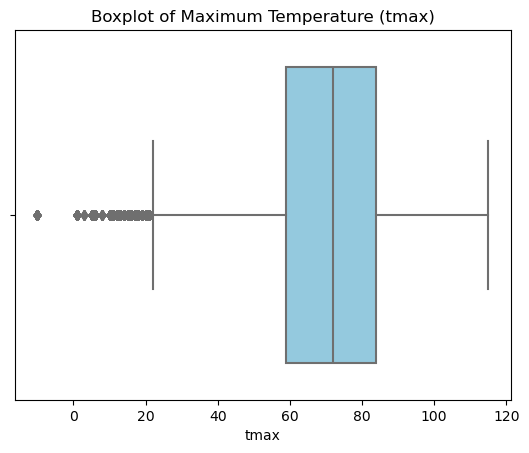

In [24]:
# Visualization of outliers
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(x=flight_df['tmax'], color='skyblue')
plt.title('Boxplot of Maximum Temperature (tmax)')
plt.show()

In [25]:
# Outlier filtering
filtered_flight_df = flight_df[(flight_df['tmax'] >= lower_bound) & (flight_df['tmax'] <= upper_bound)]
filtered_flight_df

,id,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,dep_time,dep_delay,...,destination_city_name,route,date,station,name,prcp,snow,snwd,tmax,awnd
0,1,7,WN,N204WN,682,10397,11292,605,602.0,0.0,...,"Denver, CO",10397->11292,2019-01-20,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,0.00,0.0,0.0,53.0,20.36
1,2,7,WN,N8682B,2622,10397,11292,2120,2114.0,0.0,...,"Denver, CO",10397->11292,2019-01-20,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,0.00,0.0,0.0,53.0,20.36
2,3,7,WN,N717SA,2939,10397,11292,1800,1807.0,7.0,...,"Denver, CO",10397->11292,2019-01-20,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,0.00,0.0,0.0,53.0,20.36
3,4,7,WN,N709SW,3848,10397,11292,1355,1354.0,0.0,...,"Denver, CO",10397->11292,2019-01-20,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,0.00,0.0,0.0,53.0,20.36
4,5,7,WN,N7864B,1352,10397,11697,1125,1125.0,0.0,...,"Fort Lauderdale, FL",10397->11697,2019-01-20,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,0.00,0.0,0.0,53.0,20.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057386,1382967,3,DL,N321DH,1826,13303,10397,1807,1822.0,15.0,...,"Atlanta, GA",13303->10397,2019-12-11,USW00012839,"MIAMI INTERNATIONAL AIRPORT, FL US",0.47,NaN,NaN,85.0,6.71
1057387,1382968,3,DL,N329NW,1982,13303,12953,1959,2022.0,23.0,...,"New York, NY",13303->12953,2019-12-11,USW00012839,"MIAMI INTERNATIONAL AIRPORT, FL US",0.47,NaN,NaN,85.0,6.71
1057388,1382969,3,DL,N331NW,1987,13303,10397,1125,1122.0,0.0,...,"Atlanta, GA",13303->10397,2019-12-11,USW00012839,"MIAMI INTERNATIONAL AIRPORT, FL US",0.47,NaN,NaN,85.0,6.71
1057389,1382970,3,DL,N309DN,2151,13303,12953,700,750.0,50.0,...,"New York, NY",13303->12953,2019-12-11,USW00012839,"MIAMI INTERNATIONAL AIRPORT, FL US",0.47,NaN,NaN,85.0,6.71


In [26]:
# Grouping the data by `tmax` and calculating the average delay percentage
temperature_delay_df = filtered_flight_df.groupby('tmax')['is_delayed'].mean().reset_index()

# Writing to DataFrame and rounding the value
temperature_delay_df['is_delayed'] = temperature_delay_df['is_delayed'].round(2)
temperature_delay_df

,tmax,is_delayed
0,22.0,0.30
1,23.0,0.29
2,24.0,0.23
3,25.0,0.30
4,26.0,0.17
...,...,...
89,111.0,0.17
90,112.0,0.16
91,113.0,0.17
92,114.0,0.19


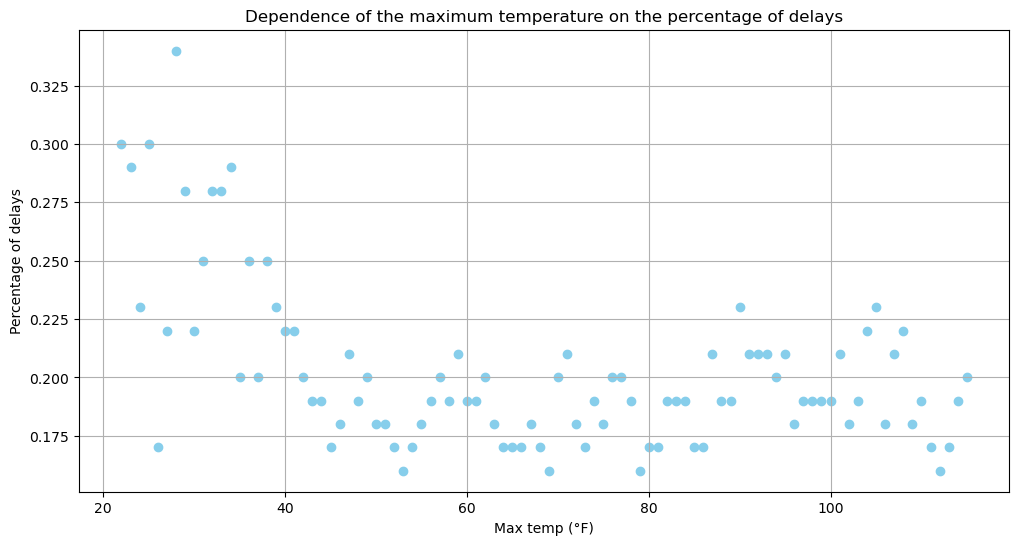

In [27]:
# Graph showing the relationship between tmax and delay percentage.

plt.figure(figsize=(12, 6))
plt.scatter(temperature_delay_df['tmax'], temperature_delay_df['is_delayed'], color='skyblue')
plt.title('Dependence of the maximum temperature on the percentage of delays')
plt.xlabel('Max temp (°F)')
plt.ylabel('Percentage of delays')
plt.grid(True)
plt.show()


It is clearly visible that the lag index is highest at low temperatures (below 40F (5C)) and its slight increase is visible at high temperatures (above 80F (26C)).

In [28]:
flight_df.to_csv(f'{result_data_path}/flight_df_03.csv', index=False)

In [29]:
filtered_flight_df.to_csv(f'{result_data_path}/filtered_flight_df_03.csv', index=False)